In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.metrics import (roc_auc_score,
                            f1_score,
                            accuracy_score,
                            confusion_matrix,
                            classification_report)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.base import clone
import optuna
SEED = 42

In [29]:
##importing data
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

##splitting into train,test and validation
active,test = train_test_split(df.drop(columns=['customerID']),test_size=1000,stratify=df.Churn,random_state=SEED)

##encoding train and val to get them to training
X,y = active.drop(columns=['Churn']),active['Churn']
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y = le.transform(test['Churn'])
X_train,X_test,y_train,y_test = train_test_split(X,y_encoded,test_size=0.2,stratify=active.Churn,random_state=SEED)

# Modelling approach
- we'll follow a full modular approach with components added through pipeline objects and columns transformers from sklearn.compose
- we'll follow the standard approach of standardization of numerical cols and OHE of categorical columns
- for changing data types or custome features we'll use custom made columns transformers

## Feature engineering 
- although the data present is raw and clean we can engineer some use full features
- we'll implement cross binning to combine two or more categorical features into one

In [4]:
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.fill_value = 0 
        self.cat_cols = ['contract_payment','internet_support','family_status','tenure_group']
        self.num_cols = ['auto_payment']
    def fit(self, X, y=None):
        temp_charges = pd.to_numeric(X['TotalCharges'], errors='coerce')
        self.fill_value = temp_charges.mean()
        return self

    def _get_cat_cols(self):
        return self.cat_cols
    def _get_num_cols(self):
        return self.num_cols
    def transform(self, X):
        X_copy = X.copy()
        # X_copy.drop(columns=['customerID'],inplace=True)
        X_copy['TotalCharges'] = pd.to_numeric(X_copy['TotalCharges'], errors='coerce')
        X_copy['TotalCharges'] = X_copy['TotalCharges'].fillna(self.fill_value)
        X_copy['contract_payment'] = X_copy['Contract'] + '_' + X_copy['PaymentMethod']
        X_copy['internet_support'] = X_copy['InternetService'] + '_' + X_copy['TechSupport']
        X_copy['family_status'] = X_copy['Partner'] + '_' + X_copy['Dependents']
        X_copy['auto_payment'] = X_copy['PaymentMethod'].apply(lambda x: 1 if 'automatic' in x else 0)
        X_copy['tenure_group'] = pd.cut(X_copy['tenure'], bins=[-1, 12, 48, 100], labels=['New', 'Established', 'Loyal'])
        X_copy['tenure_group'] = X_copy['tenure_group'].astype(str)
        
        return X_copy

## Creating Pipelines and Preprocessors

In [5]:
pre = Preprocessor()
numeric_cols = [c for c in X_train.select_dtypes(include='number').columns.tolist() if c not in ['Churn']] + ['TotalCharges'] + pre._get_num_cols()
categorical_cols = [cols for cols in X_train.select_dtypes(exclude='number').columns.tolist() if cols not in set(['customerID','TotalCharges'])] + pre._get_cat_cols()

# Define Transformers
numerical_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'
)

models = {
    'xgboost':XGBClassifier(n_estimators=1000,subsample=0.8,n_jobs=-1,random_state=SEED),
    'randomforest':RandomForestClassifier(n_estimators=500,n_jobs=-1,random_state=SEED),
    'gradientboostingclassifier':GradientBoostingClassifier(n_estimators=500,subsample=0.8,random_state=SEED),
    'logisticregression':LogisticRegression(max_iter=1000,n_jobs=-1)
}

## Baseline Training and Model Choice 

In [7]:
## training each model and evaluating baseline performance with heuristically choosen hyperparams
results = {}
X_combine = pd.concat([X_train,X_test],axis=0)
y_combine = np.concatenate([y_train,y_test],axis=0)
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=SEED)
# print(X_combine.shape)
for model_name,model in models.items():
    print(f'Training {model_name}')
    model_pipeline = Pipeline(steps=[
        ('feature_generation',pre),
        ('processor',preprocessor),
        ('model',model)
    ])

    scores = cross_val_score(model_pipeline,X_combine,y_combine,cv=cv,scoring='roc_auc',n_jobs=-1)
    results[model_name] = {
        'scores':scores,
        'avg_score':np.mean(scores),
        'std':np.std(scores)
    }

print('\n')
print('Cross Validated Baseline Scores')
for name,results in results.items():
    print(f'====={name}=====')
    for metric,res in results.items():
        if isinstance(res,np.ndarray):
            print(f'{metric}: {res}')
        else:
            print(f'{metric}: {res:.4f}')    
    print('='*10)

Training xgboost
Training randomforest
Training gradientboostingclassifier
Training logisticregression


Cross Validated Baseline Scores
=====xgboost=====
scores: [0.80191231 0.81199833 0.76974755 0.78391751 0.78536458]
avg_score: 0.7906
std: 0.0148
=====randomforest=====
scores: [0.84313695 0.8367275  0.80091248 0.81168708 0.81114014]
avg_score: 0.8207
std: 0.0163
=====gradientboostingclassifier=====
scores: [0.84520326 0.85012349 0.80947244 0.82737542 0.825856  ]
avg_score: 0.8316
std: 0.0146
=====logisticregression=====
scores: [0.85125838 0.85971836 0.82642046 0.83501197 0.84564864]
avg_score: 0.8436
std: 0.0118


#### Logistic Regression seems to outperform heavier tree based models, we'll pick it and move on to hyperparameter tuning

# Hyperparam Tuning
----
- we'll use optuna to experiment with various solvers and penalities
- optuna follows a bayesian approach in tuning parameters
- along with that we'll use 5FoldStratifiedCV by combining both the training and validation data together

In [8]:


logistic_pipeline = Pipeline(steps=[
        ('feature_generation',pre),
        ('processor',preprocessor),
        ('model',LogisticRegression())
    ])


def objective(trial):
    # --- 1. SOLVER & PENALTY SELECTION ---
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
    
    penalty = 'l2' 
    l1_ratio = None
    
    if solver == 'liblinear':
        penalty = trial.suggest_categorical('penalty_liblinear', ['l1', 'l2'])
    elif solver == 'saga':
        penalty = trial.suggest_categorical('penalty_saga', ['l1', 'l2', 'elasticnet'])
        if penalty == 'elasticnet':
            l1_ratio = trial.suggest_float('l1_ratio', 0, 1)

    # --- 2. NUMERICAL TUNING ---
    c_value = trial.suggest_float('C', 1e-4, 1e2, log=True)

    # Not a very big contributor in performance, optional at best 
    tol_value = trial.suggest_float('tol', 1e-6, 1e-3, log=True)

    # --- 3. MODEL SETUP ---
    clf = clone(logistic_pipeline)
    clf.set_params(
        model__solver=solver,
        model__penalty=penalty,
        model__C=c_value,
        model__l1_ratio=l1_ratio,
        model__class_weight='balanced',
        model__tol=tol_value,    
        model__max_iter=2500     #hardcoded, illogical to tune
    )
    
    # --- 4. RUN ---
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=SEED)

    scores = cross_val_score(clf,X_combine,y_combine,cv=cv,n_jobs=-1,scoring='roc_auc')
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50,show_progress_bar=True)

print("Best Validation AUC:", study.best_value)
print("Best Params:", study.best_params)

[I 2025-12-22 12:45:36,831] A new study created in memory with name: no-name-e56b7880-a209-45b9-b831-84b190aa0d1e
/usr/local/lib/python3.12/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-22 12:45:54,894] Trial 0 finished with value: 0.8430904901819261 and parameters: {'solver': 'saga', 'penalty_saga': 'elasticnet', 'l1_ratio': 0.24559397483497059, 'C': 45.31017904137636, 'tol': 5.7100768761020424e-05}. Best is trial 0 with value: 0.8430904901819261.
[I 2025-12-22 12:45:55,538] Trial 1 finished with value: 0.833769361058599 and parameters: {'solver': 'saga', 'penalty_saga': 'l2', 'C': 0.00015652852869692797, 'tol': 5.991500587051407e-06}. Best is trial 0 with value: 0.8430904901819261.
[I 2025-12-22 12:45:56,030] Trial 2 finished with value: 0.8433320131676156 and parameters: {'solver': 'lbfgs', 'C': 0.19126852317932572, 'tol': 2.8885241057473825e-06}. Best is trial 2 with value: 0.8433320131676156.
[I 2025-12-22 12:45:56,449] Trial 3 finished with value: 0.843096824364528 and parameters: {'solver': 'lbfgs', 'C': 17.817582328947164, 'tol': 4.29628717881723e-05}. Best is trial 2 with value: 0.8433320131676156.
[I 2025-12-22 12:46:01,425] Trial 4 finished with 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-12-22 12:47:22,211] Trial 29 finished with value: 0.843061734324648 and parameters: {'solver': 'saga', 'penalty_saga': 'elasticnet', 'l1_ratio': 0.9801648572065669, 'C': 12.669787310649738, 'tol': 1.9141552565677032e-06}. Best is trial 28 with value: 0.8441562855480192.
[I 2025-12-22 12:47:23,574] Trial 30 finished with value: 0.8442857778386548 and parameters: {'solver': 'saga', 'penalty_saga': 'l1', 'C': 0.23438607325261765, 'tol': 4.158773855081979e-06}. Best is trial 30 with value: 0.8442857778386548.
[I 2025-12-22 12:47:24,803] Trial 31 finished with value: 0.8444563873883999 and parameters: {'solver': 'saga', 'penalty_saga': 'l1', 'C': 0.19702392253215142, 'tol': 3.835210555105218e-06}. Best is trial 31 with value: 0.8444563873883999.
[I 2025-12-22 12:47:25,795] Trial 32 finished with value: 0.8445814146200622 and parameters: {'solver': 'saga', 'penalty_saga': 'l1', 'C': 0.11604349841421033, 'tol': 3.687246440451042e-06}. Best is trial 32 with value: 0.8445814146200622.
[

In [10]:
print(
    f'Best Validation AUC: {study.best_value:.3f}'
    '\n'
    f'Best Parameters: {study.best_params}'
)

Best Validation AUC: 0.845
Best Parameters: {'solver': 'saga', 'penalty_saga': 'l1', 'C': 0.09823172642497621, 'tol': 4.142905343830171e-06}


# Using cross val predictions to get the Precision-Recall curve and the custom threshold to maximize the RECALL 
- using 80% recall as the desired recall of the model (ranges between 80 to 95% in real world applications)

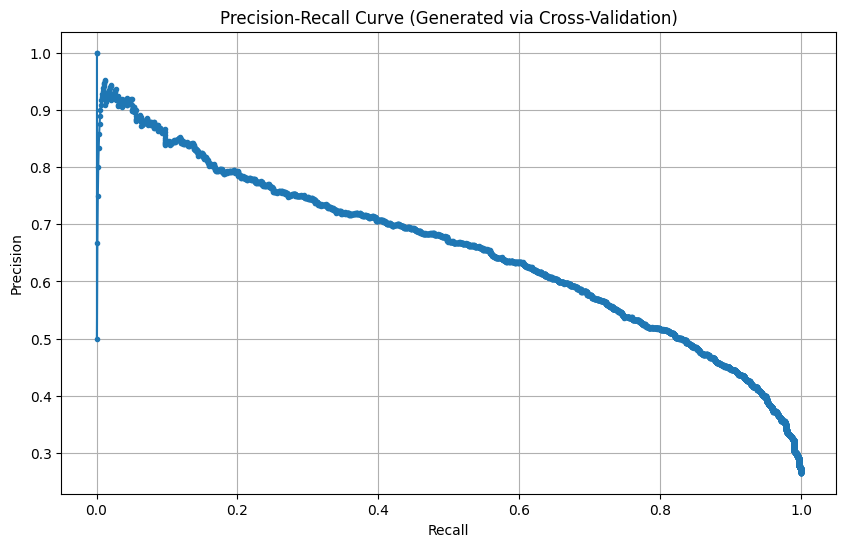

Optimal Threshold found on Training Data: 0.3832


In [41]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

X_tuning = X_combine # The data you trained your final model on
y_tuning = y_combine

clf = clone(logistic_pipeline)
clf.set_params(
    model__solver='saga',
    model__penalty='l1',
    model__C=0.09823172642497621,
    model__l1_ratio=None,
    model__class_weight='balanced',
    model__tol=4.142905343830171e-06,    
    model__max_iter=2500     #hardcoded, illogical to tune
)


y_scores_cv = cross_val_predict(
    clf, 
    X_tuning, 
    y_tuning, 
    cv=5, 
    method='predict_proba',
    n_jobs=-1
)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_tuning, y_scores_cv)


plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, marker='.', label='Logistic Regression (CV)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Generated via Cross-Validation)')
plt.grid(True)
plt.show()

import numpy as np
target_recall = 0.88
idx = np.abs(recalls - target_recall).argmin()
optimal_threshold = thresholds[idx]

print(f"Optimal Threshold found on Training Data: {optimal_threshold:.4f}")

# Testing our model on the Test data 

In [45]:
clf.fit(X_combine,y_combine)
# test['Churn'] = test['Churn'].map({'Yes':1,'No':0}) 
TEST = test.dropna()
# clf.predict_proba(TEST)[:,1]

preds = (clf.predict_proba(TEST)[:,1] > 0.3832)
# y = TEST['Churn']

print(classification_report(y,preds))
print(roc_auc_score(y,clf.predict_proba(TEST)[:,1]))

              precision    recall  f1-score   support

           0       0.95      0.61      0.74       735
           1       0.45      0.90      0.60       265

    accuracy                           0.69      1000
   macro avg       0.70      0.76      0.67      1000
weighted avg       0.81      0.69      0.70      1000

0.8453934026440764


## With custom threshold we acheive a recall of 90% and an overall auc of 0.845 (our model ranks the positive class over the negative class 85% times of chance)